In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = "../cancer_data_split/"
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')
test_dir = os.path.join(PATH, 'test')

BATCH_SIZE = 256
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 115386 files belonging to 2 classes.
Found 38461 files belonging to 2 classes.
Found 38465 files belonging to 2 classes.


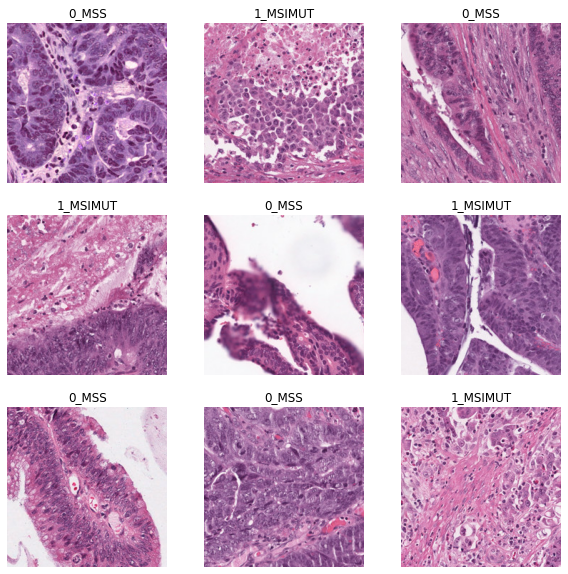

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [4]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 151
Number of test batches: 151


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [7]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [8]:
base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
flatten_layer = tf.keras.layers.Flatten()
dense_layer1 = tf.keras.layers.Dense(4096, activation='relu')
dense_layer2 = tf.keras.layers.Dense(4096, activation='relu')

In [11]:
prediction_layer = tf.keras.layers.Dense(1)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = flatten_layer(x)
x = dense_layer1(x)
x = dense_layer2(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
# Set up early stopping and model saving
early_checkpoint = EarlyStopping(patience=2, monitor='val_accuracy', mode='max')
val_acc_checkpoint = ModelCheckpoint(os.path.join("./vgg16_checkpoints", "best_acc"), monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [early_checkpoint, val_acc_checkpoint]

In [14]:
base_learning_rate = 0.000001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              167813

In [16]:
len(model.trainable_variables)

6

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Error: Kernel is dead